# Fitbit Performance Analysis

Analyze workout performance with detailed heart rate zones, activity metrics, and full-day context.

**Features:**
- Loads data from local compiled Parquet file (fast!)
- Detailed workout timeline with HR zones
- Full day context view
- Multiple workout comparison
- Easy date and activity selection

**How to use:**
1. Run cells in order
2. In cell 4, set `target_date` to the date you want to analyze
3. In cell 10, set `activity_index` to select which activity to analyze (0 = first, 1 = second, etc.)

**To update data:**
```bash
python data/compile_fitbit_data.py --update
```

## 1. Configuration - Load from Local Parquet File

In [21]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import numpy as np

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [22]:
# Import custom functions
from functions.load_data import load_single_date_from_parquet, load_date_range_from_parquet, convert_activity_distances_to_km
from functions.performance_functions import (
    plot_performance_timeline,
    plot_full_day_with_workout_highlight,
    plot_multiple_workouts_comparison,
    calculate_hr_zones_from_age,
    DEFAULT_HR_ZONES,
    PLOT_CONFIG
)

## 2. Load Local Data

This notebook uses the compiled Parquet file for faster loading. To update the compiled file, run:
```bash
python data/compile_fitbit_data.py --update
```

In [52]:
# TARGET_DATE = '2025-12-23'  # Date to analyze (YYYY-MM-DD)

In [53]:
# ===== CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory (not file!) - contains partitioned structure
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Target Date: {TARGET_DATE}")
print(f"  Data Directory: {PARQUET_PATH}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Target Date: 2025-12-23
  Data Directory: ../data
  Timezone: Europe/London


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import os
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


In [55]:
# Load parquet file and extract unique dates
if Path(PARQUET_PATH).exists():
    print(f"📂 Reading dates from: {PARQUET_PATH}\n")
    
    # Read from heartrate_intraday partitioned directory (most comprehensive coverage)
    hr_intraday_path = Path(PARQUET_PATH) / 'heartrate_intraday'
    
    if hr_intraday_path.exists():
        # Load only the time column for efficiency from partitioned structure
        df_dates = pd.read_parquet(hr_intraday_path, columns=['time'])
        
        # Ensure timezone-aware
        if df_dates['time'].dt.tz is None:
            df_dates['time'] = df_dates['time'].dt.tz_localize('UTC')
        
        # Convert to local timezone and extract dates
        df_dates['date'] = df_dates['time'].dt.tz_convert(TIMEZONE).dt.date
        
        # Get unique dates sorted
        available_dates = sorted(df_dates['date'].unique())
        
        # Display summary
        print(f"📊 Data Coverage:")
        print(f"   First date: {available_dates[0]}")
        print(f"   Last date:  {available_dates[-1]}")
        print(f"   Total days: {len(available_dates)}")
        
        # Display all dates in a compact grid format (7 columns for week view)
        print(f"\n📅 All Available Dates ({len(available_dates)} days):")
        print("=" * 80)
        
        for i, date in enumerate(available_dates):
            date_str = date.strftime('%Y-%m-%d')
            # Highlight the current TARGET_DATE if it matches
            if date_str == TARGET_DATE:
                print(f"[{date_str}]", end="  ")
            else:
                print(f" {date_str} ", end="  ")
            
            # New line after every 4 dates for readability
            if (i + 1) % 4 == 0:
                print()
        
        print("\n" + "=" * 80)
        print(f"\n💡 Tip: Current TARGET_DATE is '{TARGET_DATE}' (shown in brackets above)")
        
        # Clean up
        del df_dates
    else:
        print(f"⚠️  Heartrate intraday directory not found: {hr_intraday_path}")
        print(f"   Run the data compilation script to create partitioned structure")
    
else:
    print(f"⚠️  Data directory not found: {PARQUET_PATH}")
    print(f"   Run ./update_fitbit_data.sh to create it")

📂 Reading dates from: ../data

📊 Data Coverage:
   First date: 2025-10-03
   Last date:  2025-12-26
   Total days: 85

📅 All Available Dates (85 days):
 2025-10-03    2025-10-04    2025-10-05    2025-10-06   
 2025-10-07    2025-10-08    2025-10-09    2025-10-10   
 2025-10-11    2025-10-12    2025-10-13    2025-10-14   
 2025-10-15    2025-10-16    2025-10-17    2025-10-18   
 2025-10-19    2025-10-20    2025-10-21    2025-10-22   
 2025-10-23    2025-10-24    2025-10-25    2025-10-26   
 2025-10-27    2025-10-28    2025-10-29    2025-10-30   
 2025-10-31    2025-11-01    2025-11-02    2025-11-03   
 2025-11-04    2025-11-05    2025-11-06    2025-11-07   
 2025-11-08    2025-11-09    2025-11-10    2025-11-11   
 2025-11-12    2025-11-13    2025-11-14    2025-11-15   
 2025-11-16    2025-11-17    2025-11-18    2025-11-19   
 2025-11-20    2025-11-21    2025-11-22    2025-11-23   
 2025-11-24    2025-11-25    2025-11-26    2025-11-27   
 2025-11-28    2025-11-29    2025-11-30    2025-12

In [56]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================
# Note: Data loading functions are now imported from functions/load_data.py
# This includes:
#   - load_single_date_from_parquet()
#   - load_date_range_from_parquet()
#   - convert_activity_distances_to_km()
# See cell 3 for imports

print("✅ Using centralized data loading functions from load_data.py")

✅ Using centralized data loading functions from load_data.py


In [57]:
# Load data for target date
dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)

# Extract common DataFrames
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())
df_sleep_levels = dfs.get('SleepLevels', pd.DataFrame())
df_sleep_summary = dfs.get('SleepSummary', pd.DataFrame())

# Display summary
print(f"\n📊 Data Summary for {TARGET_DATE}:")
print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

# Check for activities
if not df_activity_records.empty:
    print(f"\n📋 Activities found: {len(df_activity_records)}")
    for idx, row in df_activity_records.iterrows():
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        activity_name = row.get('ActivityName', 'Unknown')
        distance_info = ''
        if 'distance' in row and pd.notna(row['distance']):
            distance_info = f" - {row['distance']:.2f} km"
        print(f"  {idx}. {activity_name:15s} - {duration_min:.0f} min{distance_info}")
else:
    print(f"\n⚠️  No activities found for {TARGET_DATE}")


📊 Data Summary for 2025-12-23:
HeartRate_Intraday             |  39439 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     22 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
DeviceBatteryLevel             |      1 records
ActivityRecords                |      2 records
SleepSummary                   |      2 records

📋 Activities found: 2
  1316. Swim            - 51 min 

In [58]:
# Show available dates from compiled Parquet data
import json
from pathlib import Path

compilation_state_path = Path(PARQUET_PATH) / 'compilation_state.json'

if compilation_state_path.exists():
    with open(compilation_state_path, 'r') as f:
        comp_state = json.load(f)
    
    available_dates = comp_state.get('processed_dates', [])
    
    print(f"📅 Available dates in Parquet format: {len(available_dates)} dates")
    print(f"   Range: {available_dates[0]} to {available_dates[-1]}")
    print(f"\n   Most recent 10 dates:")
    for date in reversed(available_dates[-10:]):
        if date == TARGET_DATE:
            print(f"      [{date}]  ← TARGET_DATE")
        else:
            print(f"       {date}")
else:
    print("⚠️  compilation_state.json not found")
    print(f"   Expected location: {compilation_state_path}")

📅 Available dates in Parquet format: 85 dates
   Range: 2025-10-03 to 2025-12-26

   Most recent 10 dates:
       2025-12-26
       2025-12-25
       2025-12-24
      [2025-12-23]  ← TARGET_DATE
       2025-12-22
       2025-12-21
       2025-12-20
       2025-12-19
       2025-12-18
       2025-12-17


## 4. Configure Target Date

Set the date you want to analyze below

In [81]:
# CONFIGURE: Set the date you want to analyze
target_date = '2025-12-23'

# Or use yesterday:
# target_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

print(f"Target date: {target_date}")

Target date: 2025-12-23


In [82]:
dfs = load_single_date_from_parquet(target_date, PARQUET_PATH, TIMEZONE)
print(f"\n📊 Data Summary for {target_date}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")


📊 Data Summary for 2025-12-23:
HeartRate_Intraday             |  39439 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     22 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
DeviceBatteryLevel             |      1 records
ActivityRecords                |      2 records
SleepSummary                   |      2 records

✅ Data loaded successfully


## 5. Filter Data for Selected Date

In [83]:
# Data is already loaded for the target date by load_single_date_from_parquet()
# (see cell above - this filtering is now done automatically by the Parquet loader)

print(f"📊 Data already filtered and loaded for {target_date}")
print(f"   Total measurement types: {len(dfs)}")

📊 Data already filtered and loaded for 2025-12-23
   Total measurement types: 19


In [84]:
# Data is already parsed into separate DataFrames by measurement type
# (this is done automatically by load_single_date_from_parquet)

print(f"📊 Available DataFrames for {target_date}:")
print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")
print(f"\n✅ Data ready for analysis")

📊 Available DataFrames for 2025-12-23:
HeartRate_Intraday             |  39439 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     22 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
DeviceBatteryLevel             |      1 records
ActivityRecords                |      2 records
SleepSummary                   |      2 records

✅ Data ready for analysis


In [85]:
# Extract required DataFrames
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())

# FIX: Apply miles-to-kilometers conversion for ActivityRecords
# The Parquet file stores distances in miles (as returned by Fitbit API)
# Use the same conversion logic as parse_fitbit_data() for consistency
if not df_activity_records.empty:
    df_activity_records = convert_activity_distances_to_km(df_activity_records)

print(f"\n✅ Found {len(df_hr_intra):,} HeartRate_Intraday records")
print(f"✅ Found {len(df_steps_intra):,} Steps_Intraday records")
print(f"✅ Found {len(df_activity_records)} Activity records")

# Check if we have activities
if len(df_activity_records) == 0:
    print("\n⚠️  No activities found for this date")
    print("   Try selecting a different date from the list in cell 3")
else:
    print(f"\n📋 Activities on {target_date}:")
    for idx, row in df_activity_records.iterrows():
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        activity_name = row['ActivityName'] if 'ActivityName' in row else 'Unknown'
        distance_info = ''
        if 'distance' in row and pd.notna(row['distance']):
            distance_info = f" - {row['distance']:.2f} km"
            if 'distance_miles' in row and pd.notna(row['distance_miles']):
                distance_info += f" (was {row['distance_miles']:.2f} mi)"
        print(f"  {idx}. {activity_name:15s} - {duration_min:.0f} min{distance_info} at {row['time']}")


✅ Found 39,439 HeartRate_Intraday records
✅ Found 1,440 Steps_Intraday records
✅ Found 2 Activity records

📋 Activities on 2025-12-23:
  1316. Swim            - 51 min - 2.40 km (was 1.49 mi) at 2025-12-23 20:01:54+00:00
  1317. Walk            - 14 min - 0.94 km (was 0.58 mi) at 2025-12-23 08:43:07.053000+00:00


## 6. Detailed Workout Analysis

View detailed performance timeline for a specific workout

In [86]:
# OPTIONAL: Calculate personalized HR zones based on age
# Uncomment and set your age to use personalized zones
# my_age = 35
# my_resting_hr = 60
# hr_zones = calculate_hr_zones_from_age(my_age, my_resting_hr)

# Use default zones
hr_zones = DEFAULT_HR_ZONES

print("Heart Rate Zones:")
for zone, info in hr_zones.items():
    print(f"  {zone:15s}: {info['range'][0]:3d} - {info['range'][1]:3d} bpm")

Heart Rate Zones:
  Out of Range   :   0 -  93 bpm
  Fat Burn       :  93 - 128 bpm
  Cardio         : 128 - 155 bpm
  Peak           : 155 - 220 bpm


Analyzing activity 0:
  Swim at 2025-12-23 20:01:54+00:00



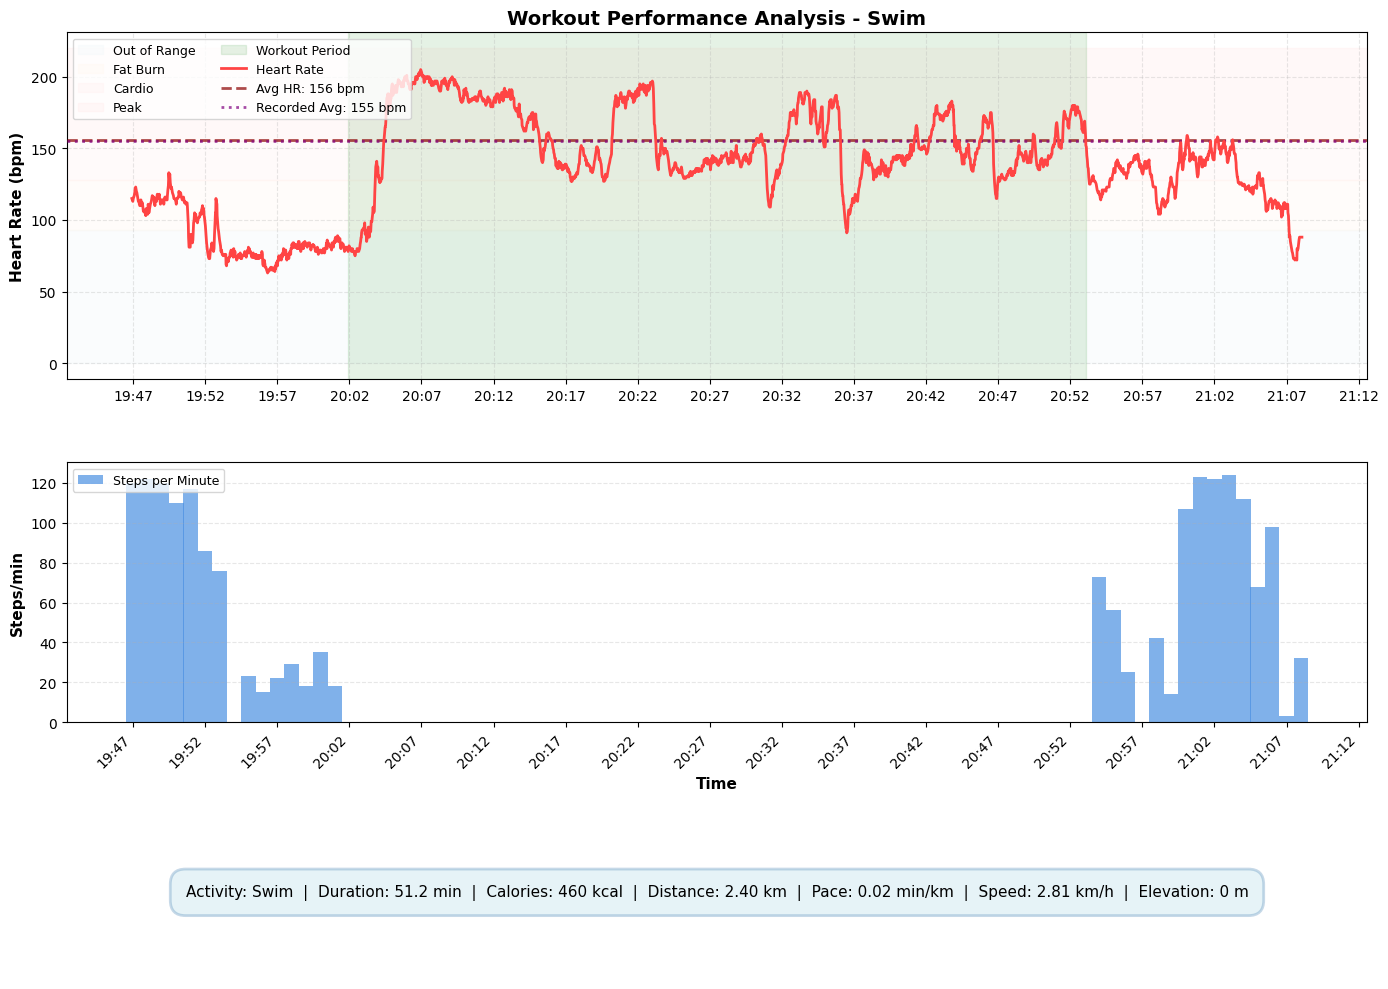

In [87]:
# CONFIGURE: Select which activity to analyze
# Change this to 0 for first activity, 1 for second, etc.
# The activity list is shown in the cell above
activity_index = 0

if len(df_activity_records) > 0:
    try:
        selected_activity = df_activity_records.iloc[activity_index]
        
        print(f"Analyzing activity {activity_index}:")
        activity_name = selected_activity['ActivityName'] if 'ActivityName' in selected_activity else 'Unknown'
        print(f"  {activity_name} at {selected_activity['time']}\n")
        
        fig = plot_performance_timeline(
            df_hr_intra,
            df_steps_intra,
            selected_activity,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except IndexError:
        print(f"❌ Activity index {activity_index} not found.")
        print(f"   Available indices: 0 to {len(df_activity_records)-1}")
        print(f"   Please update 'activity_index' in the cell above")
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("❌ No activities to plot")
    print("   Try selecting a different date")

## 7. Full Day Context View

View the entire day with workout highlighted

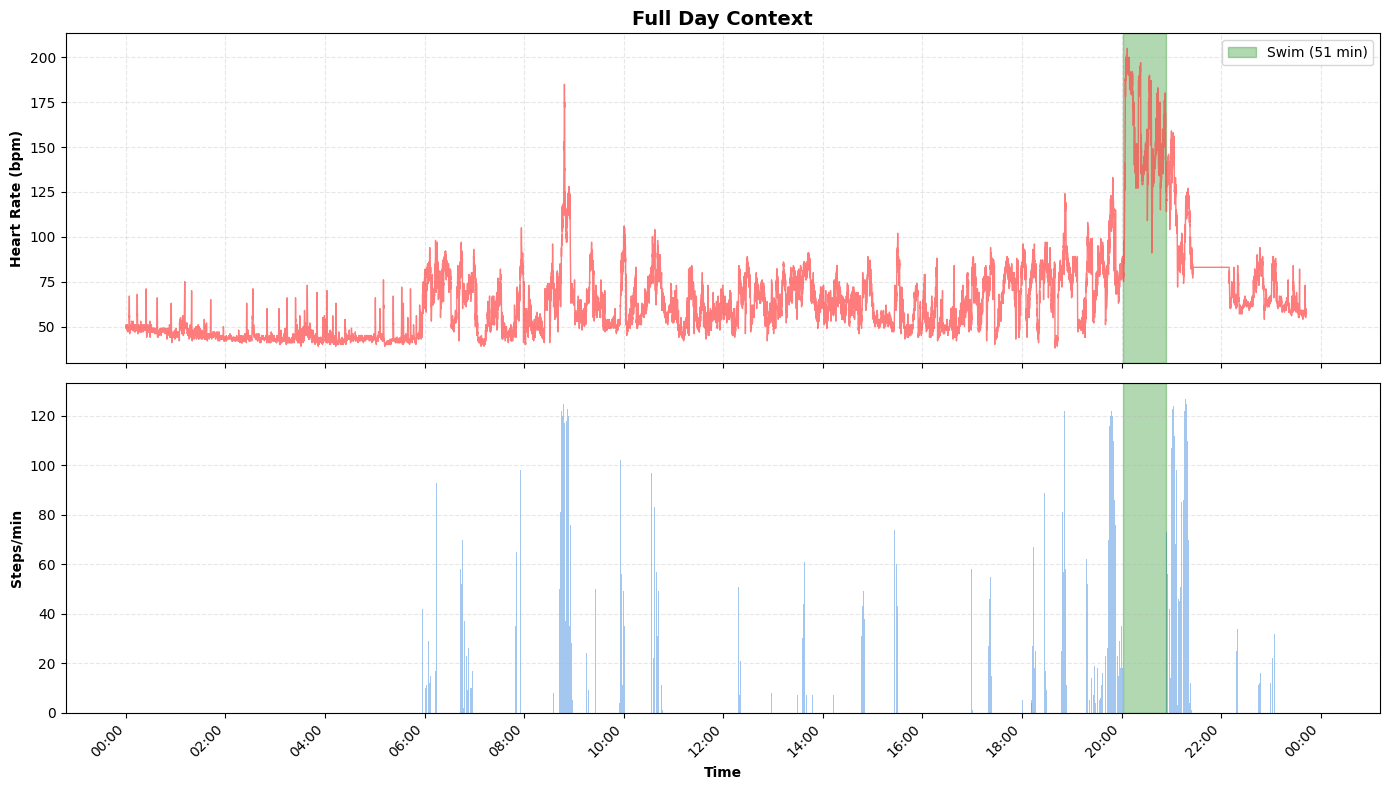

In [88]:
if len(df_activity_records) > 0:
    try:
        # Reset index to ensure iloc works correctly
        df_activities_indexed = df_activity_records.reset_index(drop=True)
        
        fig = plot_full_day_with_workout_highlight(
            df_hr_intra,
            df_steps_intra,
            df_activities_indexed.iloc[activity_index],
            timezone='Europe/London'
        )
        plt.show()
    except IndexError:
        print(f"❌ Activity index {activity_index} not found.")
        print(f"   Available indices: 0 to {len(df_activity_records)-1}")
    except Exception as e:
        print(f"❌ Error plotting: {e}")

## 8. Multiple Workouts Comparison (Optional)

Compare multiple workouts from the same day

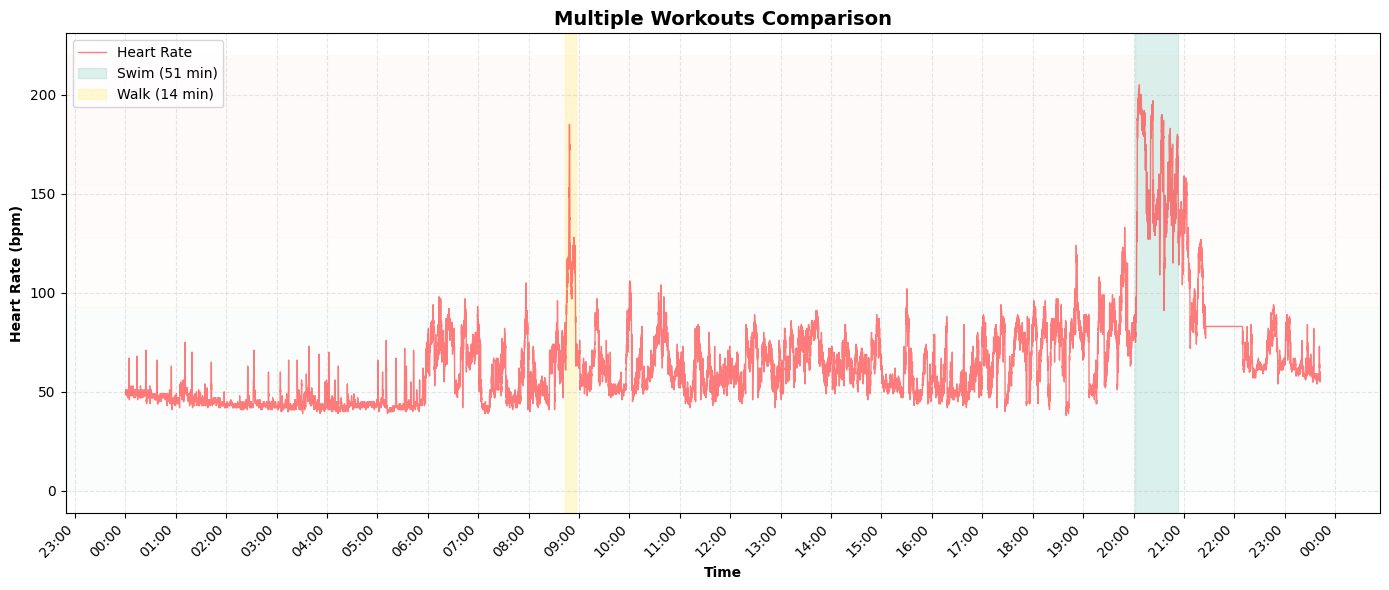

In [89]:
if len(df_activity_records) > 1:
    try:
        fig = plot_multiple_workouts_comparison(
            df_hr_intra,
            df_steps_intra,
            df_activity_records,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("Only one activity found - comparison requires multiple workouts")

## 9. Activity Details

View detailed metrics for all activities

In [90]:
if len(df_activity_records) > 0:
    # Select relevant columns
    cols_to_show = [
        'time', 'ActivityName', 'calories', 'distance', 'steps',
        'speed', 'pace', 'averageHeartRate', 'duration',
        'elevationGain'
    ]
    
    # Filter columns that exist
    available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
    print("\n📊 Activity Details:")
    print("="*100)
    display(df_activity_records[available_cols])
else:
    print("No activities found")


📊 Activity Details:


,time,ActivityName,calories,distance,steps,speed,pace,averageHeartRate,duration,elevationGain
1316,2025-12-23 20:01:54+00:00,Swim,460.0,2.400000,NaN,2.814333,1279.166548,155.0,3070000.0,0.0
1317,2025-12-23 08:43:07.053000+00:00,Walk,101.0,0.935199,1229.0,4.066085,885.372629,109.0,828000.0,0.0


## 9a. Run/Workout-Specific Analysis

Detailed analysis for ALL running and workout sessions (treadmill and outdoor runs).

**✅ Distance Fix Applied:** Fitbit API returns distances in **miles**. This notebook automatically converts to kilometers and recalculates pace/speed.

In [91]:
# Find ALL running/workout activities (GPS and non-GPS)
run_activity_names = ['Run', 'Jog', 'Structured Workout', 'Outdoor Run', 'Treadmill Run', 'Treadmill run', 'Sport']
run_activities = df_activity_records[
    df_activity_records['ActivityName'].isin(run_activity_names)
].copy()

if len(run_activities) > 0:
    print(f"Found {len(run_activities)} running/workout session(s)\n")
    
    for idx, run in run_activities.iterrows():
        print(f"{'='*80}")
        print(f"RUN ANALYSIS - {run['ActivityName']} - {run['time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"{'='*80}\n")
        
        # Check if this has distance data
        if 'distance' not in run or pd.isna(run['distance']) or run['distance'] == 0:
            print("⚠️  No distance data available for this activity\n")
            continue
        
        # Basic metrics
        distance_km = run['distance']  # Already converted from miles to km
        duration_sec = run['duration'] / 1000
        duration_min = duration_sec / 60
        
        # Check if this was originally in miles (has distance_miles field)
        if 'distance_miles' in run and pd.notna(run['distance_miles']):
            print(f"📏 Distance: {distance_km:.2f} km (converted from {run['distance_miles']:.2f} miles)")
        else:
            print(f"📏 Distance: {distance_km:.2f} km")
        
        print(f"⏱️  Duration: {int(duration_min)}:{int((duration_min % 1) * 60):02d} ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {run['calories']:.0f} kcal")
        
        if 'steps' in run and pd.notna(run['steps']):
            print(f"👣 Steps: {run['steps']:.0f}")
        
        if 'averageHeartRate' in run and pd.notna(run['averageHeartRate']):
            print(f"❤️  Average HR: {run['averageHeartRate']:.0f} bpm")
        
        # Pace and speed
        pace_per_km = run['pace']  # seconds per km (already recalculated)
        pace_min = int(pace_per_km // 60)
        pace_sec = int(pace_per_km % 60)
        speed_kmh = run['speed']  # Already recalculated
        
        print(f"\n⚡ Performance Metrics:")
        print(f"   Pace: {pace_min}:{pace_sec:02d} min/km ({pace_per_km:.0f} sec/km)")
        print(f"   Speed: {speed_kmh:.2f} km/h")
        
        # Cadence (steps per minute) - only if steps available
        if 'steps' in run and pd.notna(run['steps']) and run['steps'] > 0:
            cadence = (run['steps'] / duration_min)
            print(f"   Cadence: {cadence:.0f} steps/min")
        
        # Elevation
        if 'elevationGain' in run and pd.notna(run['elevationGain']):
            elevation_gain = run['elevationGain']
            print(f"   Elevation Gain: {elevation_gain:.0f} m")
        
        # Kilometer splits (estimated from average pace)
        if distance_km >= 1.0:
            print(f"\n📊 Estimated Kilometer Splits:")
            print(f"   (Based on average pace - actual splits may vary)")
            print(f"   {'KM':>3s} | {'Split Time':>12s} | {'Elapsed':>10s}")
            print(f"   {'-'*3:3s}-+-{'-'*12:12s}-+-{'-'*10:10s}")
            
            for km in range(1, int(distance_km) + 1):
                # Elapsed time at this km
                elapsed_sec = pace_per_km * km
                elapsed_min = int(elapsed_sec // 60)
                elapsed_sec_remainder = int(elapsed_sec % 60)
                
                # Split time (same as pace for constant speed)
                split_min = pace_min
                split_sec = pace_sec
                
                print(f"   {km:3d} | {split_min:2d}:{split_sec:02d} min/km | {elapsed_min:3d}:{elapsed_sec_remainder:02d}")
            
            # Final partial km if any
            remaining_distance = distance_km - int(distance_km)
            if remaining_distance >= 0.1:  # At least 100m
                elapsed_sec = duration_sec
                elapsed_min = int(elapsed_sec // 60)
                elapsed_sec_remainder = int(elapsed_sec % 60)
                
                partial_time_sec = remaining_distance * pace_per_km
                partial_min = int(partial_time_sec // 60)
                partial_sec = int(partial_time_sec % 60)
                
                print(f"  {remaining_distance:4.2f} | {partial_min:2d}:{partial_sec:02d}         | {elapsed_min:3d}:{elapsed_sec_remainder:02d}")
        
        # Efficiency metrics
        print(f"\n📊 Efficiency Metrics:")
        print(f"   Calories per km: {(run['calories'] / distance_km):.1f} kcal/km")
        
        if 'steps' in run and pd.notna(run['steps']) and run['steps'] > 0:
            print(f"   Steps per km: {(run['steps'] / distance_km):.0f} steps/km")
            print(f"   Meters per step: {(distance_km * 1000 / run['steps']):.2f} m/step")
        
        # Check for GPS data
        df_gps = dfs.get('GPS', pd.DataFrame())
        has_gps = False
        
        if not df_gps.empty:
            activity_id = f"{run['time'].isoformat()}-{run['ActivityName']}"
            run_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            if not run_gps.empty:
                has_gps = True
                gps_distance_km = run_gps['distance'].max() / 1000
                print(f"\n🛰️  GPS Data:")
                print(f"   GPS trackpoints: {len(run_gps):,}")
                print(f"   GPS distance: {gps_distance_km:.2f} km")
                print(f"   API distance: {distance_km:.2f} km")
                diff_m = abs(gps_distance_km - distance_km) * 1000
                print(f"   Difference: {diff_m:.0f} meters")
                
                if diff_m < 50:
                    print(f"   ✅ Excellent GPS match!")
                elif diff_m < 100:
                    print(f"   ✅ Good GPS match")
        
        if not has_gps:
            print(f"\n📍 No GPS data (typical for treadmill runs)")
        
        # Heart rate analysis during the run (from intraday HR data)
        if not df_hr_intra.empty:
            from functions.performance_functions import extract_activity_time_window
            
            try:
                run_start, run_end, run_duration = extract_activity_time_window(run, 'Europe/London')
                
                # Get HR data during this run
                hr_during_run = df_hr_intra[
                    (df_hr_intra['time'] >= run_start) & 
                    (df_hr_intra['time'] <= run_end)
                ].copy()
                
                if not hr_during_run.empty and len(hr_during_run) > 0:
                    print(f"\n❤️  Heart Rate Analysis (from {len(hr_during_run):,} measurements):")
                    print(f"   Average: {hr_during_run['value'].mean():.0f} bpm")
                    print(f"   Min: {hr_during_run['value'].min():.0f} bpm")
                    print(f"   Max: {hr_during_run['value'].max():.0f} bpm")
                    print(f"   Median: {hr_during_run['value'].median():.0f} bpm")
                    
                    # HR zone distribution
                    print(f"\n   HR Zone Distribution:")
                    for zone_name, zone_info in hr_zones.items():
                        hr_in_zone = hr_during_run[
                            (hr_during_run['value'] >= zone_info['range'][0]) &
                            (hr_during_run['value'] < zone_info['range'][1])
                        ]
                        pct = (len(hr_in_zone) / len(hr_during_run)) * 100
                        if pct > 0:
                            time_in_zone_min = len(hr_in_zone) / 60  # ~1 second per measurement
                            print(f"     {zone_name:15s}: {pct:5.1f}% ({time_in_zone_min:5.1f} min)")
            except Exception as e:
                print(f"\n⚠️  Could not analyze HR data: {e}")
        
        print(f"\n")
else:
    print("No running/workout activities found for this date")
    print("\nActivities searched:")
    for name in run_activity_names:
        print(f"  - {name}")

No running/workout activities found for this date

Activities searched:
  - Run
  - Jog
  - Structured Workout
  - Outdoor Run
  - Treadmill Run
  - Treadmill run
  - Sport


In [92]:
# Visualize pace variation and heart rate for GPS-tracked runs
df_gps = dfs.get('GPS', pd.DataFrame())

if len(run_activities) > 0 and not df_gps.empty:
    # Check what columns the GPS data has
    if 'ActivityID' not in df_gps.columns:
        print("⚠️  GPS data doesn't have ActivityID column")
        print(f"   Available columns: {list(df_gps.columns)}")
        print("\n   This cell requires GPS data with ActivityID to match activities.")
        print("   Skipping GPS visualization.\n")
    else:
        for idx, run in run_activities.iterrows():
            # Convert datetime to ISO format string to match GPS ActivityID format
            time_str = run['time'].isoformat()
            activity_id = f"{time_str}-{run['ActivityName']}"
            run_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            if not run_gps.empty and 'heart_rate' in run_gps:
                print(f"Visualizing: {run['ActivityName']} - {run['time'].strftime('%Y-%m-%d %H:%M')}\n")
                
                run_gps = run_gps.sort_values('distance')
                run_gps['time'] = pd.to_datetime(run_gps['time'])
                
                # Calculate rolling pace (pace for each 100m segment)
                run_gps['distance_km'] = run_gps['distance'] / 1000
                
                # Create figure with 3 subplots
                fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
                
                # ================================================================
                # Plot 1: Heart Rate and Pace over Distance
                # ================================================================
                
                ax1_twin = ax1.twinx()
                
                # Plot heart rate
                ax1.plot(run_gps['distance_km'], run_gps['heart_rate'], 
                        color='#ff4444', linewidth=2, label='Heart Rate', alpha=0.8)
                ax1.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color='#ff4444')
                ax1.tick_params(axis='y', labelcolor='#ff4444')
                ax1.grid(True, alpha=0.3)
                
                # Calculate rolling pace (using 200m windows)
                window_size = 40  # ~200m at 5m per point
                if len(run_gps) > window_size:
                    run_gps['time_diff'] = run_gps['time'].diff().dt.total_seconds()
                    run_gps['dist_diff'] = run_gps['distance'].diff()
                    run_gps['rolling_pace'] = (run_gps['time_diff'] / (run_gps['dist_diff'] / 1000))
                    
                    # Remove outliers (pace < 2 min/km or > 20 min/km)
                    run_gps.loc[(run_gps['rolling_pace'] < 120) | (run_gps['rolling_pace'] > 1200), 'rolling_pace'] = np.nan
                    
                    # Smooth the pace data
                    run_gps['rolling_pace_smooth'] = run_gps['rolling_pace'].rolling(window=window_size, center=True).mean()
                    
                    # Convert to min/km for display
                    run_gps['pace_min_km'] = run_gps['rolling_pace_smooth'] / 60
                    
                    ax1_twin.plot(run_gps['distance_km'], run_gps['pace_min_km'],
                                color='#4444ff', linewidth=2, label='Pace', alpha=0.6)
                    ax1_twin.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold', color='#4444ff')
                    ax1_twin.tick_params(axis='y', labelcolor='#4444ff')
                    ax1_twin.invert_yaxis()  # Faster pace at top
                
                ax1.set_title(f'{run["ActivityName"]} - Heart Rate & Pace Profile', 
                             fontsize=14, fontweight='bold')
                
                # ================================================================
                # Plot 2: Elevation Profile
                # ================================================================
                
                if 'altitude' in run_gps:
                    ax2.fill_between(run_gps['distance_km'], run_gps['altitude'], 
                                    alpha=0.3, color='#8B4513')
                    ax2.plot(run_gps['distance_km'], run_gps['altitude'], 
                            color='#8B4513', linewidth=2, label='Elevation')
                    ax2.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                    ax2.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
                    ax2.set_title('Elevation Profile', fontsize=14, fontweight='bold')
                    ax2.grid(True, alpha=0.3)
                    
                    # Add stats
                    elev_gain = run.get('elevationGain', 0)
                    elev_range = run_gps['altitude'].max() - run_gps['altitude'].min()
                    ax2.text(0.02, 0.98, f'Gain: {elev_gain:.0f}m | Range: {elev_range:.0f}m',
                            transform=ax2.transAxes, va='top', fontsize=10,
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                # ================================================================
                # Plot 3: Kilometer Splits Bar Chart
                # ================================================================
                
                distance_km = run['distance']
                splits_data = []
                
                for km in range(1, int(distance_km) + 1):
                    km_distance_m = km * 1000
                    closest_idx = (run_gps['distance'] - km_distance_m).abs().idxmin()
                    km_point = run_gps.loc[closest_idx]
                    
                    if km == 1:
                        prev_point = run_gps.iloc[0]
                    else:
                        prev_km_m = (km - 1) * 1000
                        prev_idx = (run_gps['distance'] - prev_km_m).abs().idxmin()
                        prev_point = run_gps.loc[prev_idx]
                    
                    split_seconds = (km_point['time'] - prev_point['time']).total_seconds()
                    km_actual_distance = (km_point['distance'] - prev_point['distance']) / 1000
                    
                    if km_actual_distance > 0:
                        split_pace = split_seconds / km_actual_distance
                        splits_data.append({'km': km, 'pace': split_pace})
                
                if splits_data:
                    splits_df = pd.DataFrame(splits_data)
                    
                    # Color bars by pace (faster = green, slower = red)
                    avg_pace = splits_df['pace'].mean()
                    colors = ['#00aa00' if p <= avg_pace else '#aa0000' for p in splits_df['pace']]
                    
                    bars = ax3.bar(splits_df['km'], splits_df['pace'] / 60, color=colors, 
                                  edgecolor='black', linewidth=1.5, alpha=0.7)
                    
                    # Add pace labels on bars
                    for bar, pace in zip(bars, splits_df['pace']):
                        height = bar.get_height()
                        pace_min = int(pace // 60)
                        pace_sec = int(pace % 60)
                        ax3.text(bar.get_x() + bar.get_width()/2., height,
                               f'{pace_min}:{pace_sec:02d}',
                               ha='center', va='bottom', fontsize=9, fontweight='bold')
                    
                    # Add average pace line
                    ax3.axhline(avg_pace / 60, color='blue', linestyle='--', linewidth=2, 
                               label=f'Avg: {int(avg_pace//60)}:{int(avg_pace%60):02d}', alpha=0.7)
                    
                    ax3.set_xlabel('Kilometer', fontsize=12, fontweight='bold')
                    ax3.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold')
                    ax3.set_title('Kilometer Splits (Green = faster than avg, Red = slower)', 
                                 fontsize=14, fontweight='bold')
                    ax3.set_xticks(splits_df['km'])
                    ax3.legend()
                    ax3.grid(True, alpha=0.3, axis='y')
                
                plt.tight_layout()
                plt.show()
                
                print("\n" + "="*80)
else:
    if len(run_activities) == 0:
        print("No running activities found to visualize")
    elif df_gps.empty:
        print("No GPS data available (typical for treadmill runs)")

No running activities found to visualize


## 10. Swim-Specific Analysis

Detailed analysis for swimming sessions including pace per 100m, GPS data, and heart rate during swim

**⚠️ Known Issue:** Fitbit API returns swim distances in **miles** (not km like other activities). This notebook converts them correctly, but `fitbit2s3.py` should be updated to handle this at the data collection stage for future consistency.

In [93]:
# Configuration
POOL_LENGTH = 25  # meters
MILES_TO_KM = 1.609344  # Conversion factor

# Find all swim activities
swim_activities = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].copy()

if len(swim_activities) > 0:
    print(f"Found {len(swim_activities)} swim session(s)\n")
    
    for idx, swim in swim_activities.iterrows():
        print(f"{'='*80}")
        print(f"SWIM SESSION ANALYSIS - {swim['time']}")
        print(f"{'='*80}\n")
        
        # FIX: Fitbit API returns swim distances in MILES, not kilometers!
        # Convert to meters correctly
        distance_from_api = swim['distance']  # This is in MILES for swimming
        distance_m = distance_from_api * MILES_TO_KM * 1000  # Convert miles -> km -> meters
        distance_km = distance_m / 1000
        
        print(f"⚠️ Note: Fitbit returns swim distance in miles ({distance_from_api:.3f} mi)")
        print(f"📏 Distance: {distance_m:.0f} meters ({distance_km:.2f} km)")
        
        # Duration
        duration_min = swim['duration'] / 1000 / 60
        duration_sec = swim['duration'] / 1000
        
        print(f"⏱️ Duration: {duration_min:.1f} minutes ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {swim['calories']:.0f} kcal")
        
        # Recalculate speed with correct distance
        speed_kmh = (distance_km / duration_sec) * 3600
        print(f"⚡ Speed: {speed_kmh:.2f} km/h\n")
        
        # Calculate pace per 100m with CORRECT distance
        pace_sec_per_100m = duration_sec / (distance_m / 100)
        pace_min = int(pace_sec_per_100m // 60)
        pace_sec = int(pace_sec_per_100m % 60)
        
        print(f"🏊 Pace per 100m: {pace_min}:{pace_sec:02d} min/100m")
        
        # Laps in 25m pool
        laps = distance_m / POOL_LENGTH
        complete_laps = int(laps)
        
        print(f"\n🔄 Laps ({POOL_LENGTH}m pool): {laps:.1f} laps ({complete_laps} complete laps)")
        
        # Length breakdown
        complete_lengths = int(distance_m / POOL_LENGTH)
        remaining_meters = distance_m % POOL_LENGTH
        print(f"   = {complete_lengths} lengths", end='')
        if remaining_meters >= 1:
            print(f" + {remaining_meters:.0f}m")
        else:
            print()
        
        # Average time per lap
        if complete_laps > 0:
            sec_per_lap = duration_sec / laps
            lap_min = int(sec_per_lap // 60)
            lap_sec = int(sec_per_lap % 60)
            print(f"   Average time per lap: {lap_min}:{lap_sec:02d}")
        
        print(f"\n📊 Additional Metrics:")
        print(f"   Calories per 100m: {(swim['calories'] / (distance_m / 100)):.1f} kcal")
        print(f"   Meters per minute: {distance_m / duration_min:.1f} m/min")
        
        print(f"\n")
else:
    print("No swim activities found for this date")

Found 1 swim session(s)

SWIM SESSION ANALYSIS - 2025-12-23 20:01:54+00:00

⚠️ Note: Fitbit returns swim distance in miles (2.400 mi)
📏 Distance: 3862 meters (3.86 km)
⏱️ Duration: 51.2 minutes (3070 seconds)
🔥 Calories: 460 kcal
⚡ Speed: 4.53 km/h

🏊 Pace per 100m: 1:19 min/100m

🔄 Laps (25m pool): 154.5 laps (154 complete laps)
   = 154 lengths + 12m
   Average time per lap: 0:19

📊 Additional Metrics:
   Calories per 100m: 11.9 kcal
   Meters per minute: 75.5 m/min




In [94]:
# Debug: Check what activity types are available in the data
print("="*80)
print("ACTIVITY TYPES IN DATA")
print("="*80)

if not df_activity_records.empty:
    activity_types = df_activity_records['ActivityName'].value_counts()
    
    print(f"\nFound {len(activity_types)} different activity types:")
    print(f"\n{'Activity Type':30s} | Count")
    print("-" * 45)
    for activity_type, count in activity_types.items():
        print(f"{activity_type:30s} | {count:5d}")
    
    # Check for swimming activities
    swim_activities = df_activity_records[
        df_activity_records['ActivityName'].str.contains('Swim', case=False, na=False)
    ]
    
    if not swim_activities.empty:
        print(f"\n✅ Found {len(swim_activities)} swim activity/activities!")
        for idx, swim in swim_activities.iterrows():
            print(f"   - {swim['ActivityName']} on {swim['time']}")
    else:
        print(f"\n⚠️  No swim activities found in the current date ({target_date})")
        print(f"   Try selecting a different date that includes swimming")
else:
    print("\n⚠️  No activity records found")
    print(f"   Check that target_date ({target_date}) has activity data")

ACTIVITY TYPES IN DATA

Found 2 different activity types:

Activity Type                  | Count
---------------------------------------------
Swim                           |     1
Walk                           |     1

✅ Found 1 swim activity/activities!
   - Swim on 2025-12-23 20:01:54+00:00


In [95]:
# Check for GPS data
df_gps = dfs.get('GPS', pd.DataFrame())

if not df_gps.empty:
    print(f"✅ Found {len(df_gps)} GPS trackpoints\n")
    print(df_gps.head(10))
else:
    print("⚠️  No GPS data found (expected for pool swimming)\n")

# Check if there's heart rate data during swim sessions
if len(swim_activities) > 0 and not df_hr_intra.empty:
    print(f"\n{'='*80}")
    print("HEART RATE DURING SWIM")
    print(f"{'='*80}\n")
    
    for idx, swim in swim_activities.iterrows():
        # Extract activity time window
        from functions.performance_functions import extract_activity_time_window
        swim_start, swim_end, duration = extract_activity_time_window(swim, 'Europe/London')
        
        # Filter HR data to swim window
        hr_during_swim = df_hr_intra[
            (df_hr_intra['time'] >= swim_start) & 
            (df_hr_intra['time'] <= swim_end)
        ].copy()
        
        if not hr_during_swim.empty:
            print(f"Swim at {swim['time']}:")
            print(f"  ✅ Found {len(hr_during_swim)} heart rate measurements during swim")
            print(f"  📊 HR Statistics:")
            print(f"     - Average: {hr_during_swim['value'].mean():.1f} bpm")
            print(f"     - Min: {hr_during_swim['value'].min():.0f} bpm")
            print(f"     - Max: {hr_during_swim['value'].max():.0f} bpm")
            print(f"     - Median: {hr_during_swim['value'].median():.1f} bpm\n")
            
            # Show HR distribution
            print(f"  HR Zone Distribution:")
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_swim[
                    (hr_during_swim['value'] >= zone_info['range'][0]) &
                    (hr_during_swim['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_swim)) * 100
                print(f"     - {zone_name:15s}: {pct:5.1f}% ({len(hr_in_zone):4d} measurements)")
        else:
            print(f"  ⚠️  No heart rate data found during swim (watch may not track HR in water)\n")

⚠️  No GPS data found (expected for pool swimming)


HEART RATE DURING SWIM

Swim at 2025-12-23 20:01:54+00:00:
  ✅ Found 1577 heart rate measurements during swim
  📊 HR Statistics:
     - Average: 155.8 bpm
     - Min: 75 bpm
     - Max: 205 bpm
     - Median: 151.0 bpm

  HR Zone Distribution:
     - Out of Range   :   2.5% (  40 measurements)
     - Fat Burn       :   5.8% (  92 measurements)
     - Cardio         :  45.1% ( 712 measurements)
     - Peak           :  46.5% ( 733 measurements)


Plotting swim session from 2025-12-23 20:01:54+00:00



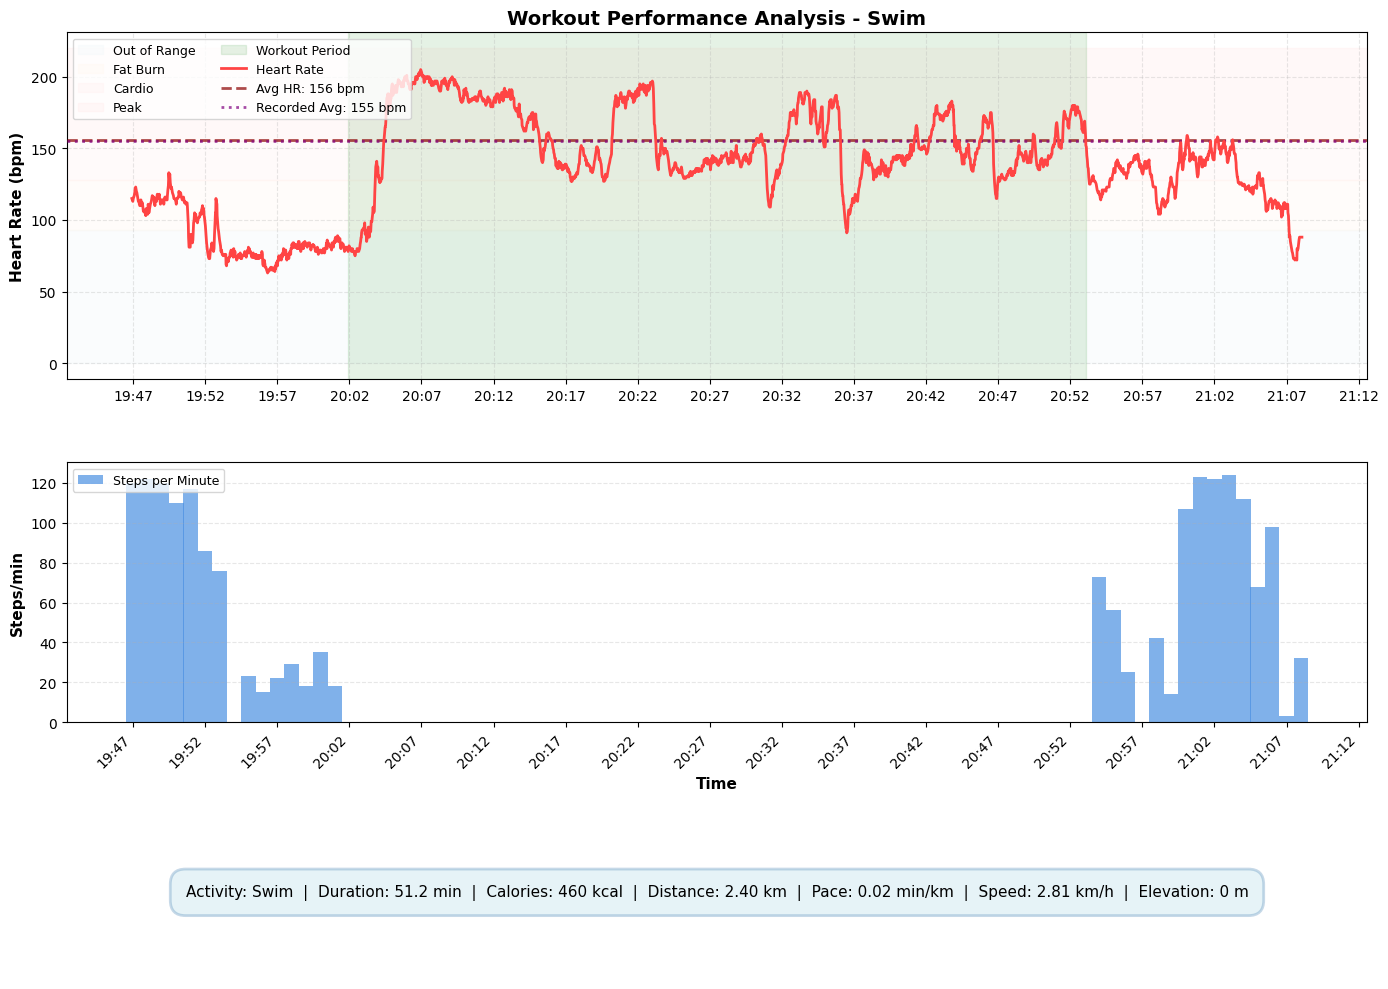

In [96]:
# Plot swim session if activity_index points to a swim
if len(df_activity_records) > 0:
    # Check if we have any swim in the records
    swim_indices = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].index.tolist()
    
    if len(swim_indices) > 0:
        # Use the first swim activity
        swim_idx = 0  # Change this to analyze different swim sessions
        
        try:
            selected_swim = df_activity_records.iloc[swim_idx]
            
            if selected_swim['ActivityName'] == 'Swim':
                print(f"Plotting swim session from {selected_swim['time']}\n")
                
                fig = plot_performance_timeline(
                    df_hr_intra,
                    df_steps_intra,
                    selected_swim,
                    hr_zones=hr_zones,
                    timezone='Europe/London'
                )
                plt.show()
            else:
                print(f"Activity at index {swim_idx} is not a swim session (it's {selected_swim['ActivityName']})")
                print(f"Swim sessions are at indices: {swim_indices}")
        except Exception as e:
            print(f"Error plotting swim: {e}")
    else:
        print("No swim sessions found to plot")

## 11. Heart Rate Zone Analysis

Visualize time spent in different heart rate zones throughout the day

Analyzing 39,439 heart rate measurements



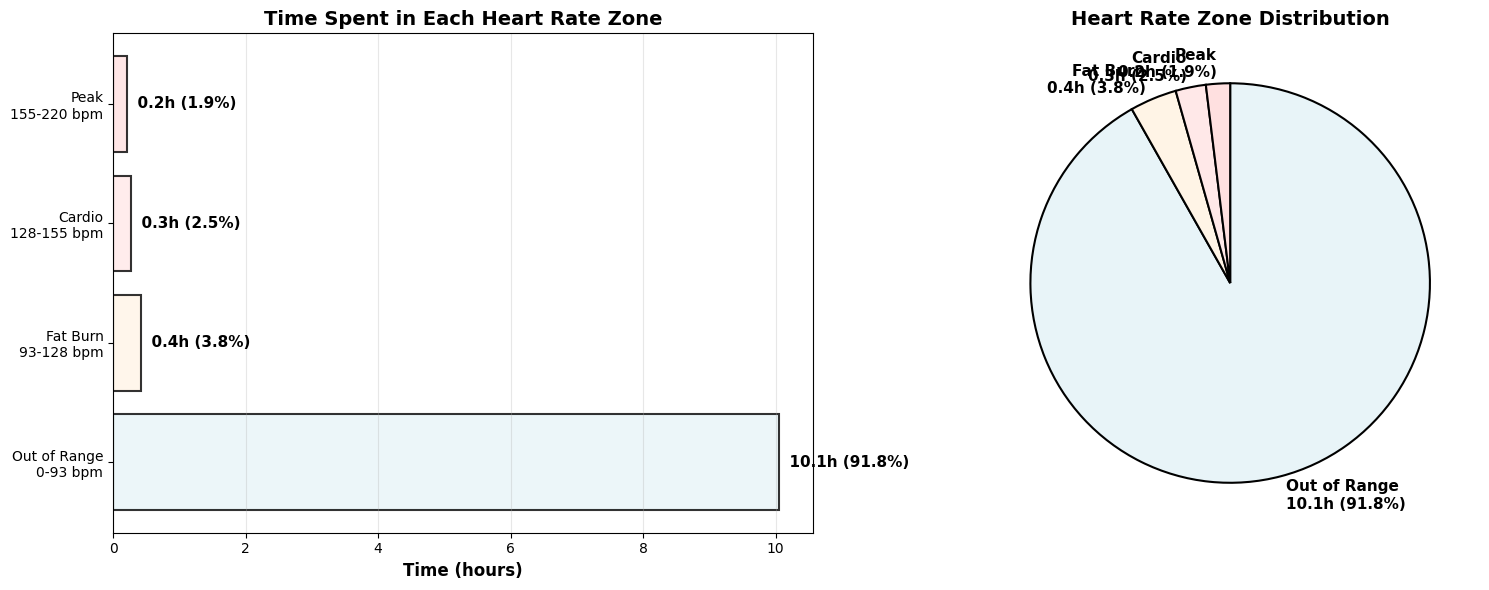


HEART RATE ZONE SUMMARY

Out of Range    (0-93 bpm)
  Time: 10.1 hours (603 minutes)
  Percentage: 91.8%
  Measurements: 36,208

Fat Burn        (93-128 bpm)
  Time: 0.4 hours (25 minutes)
  Percentage: 3.8%
  Measurements: 1,497

Cardio          (128-155 bpm)
  Time: 0.3 hours (16 minutes)
  Percentage: 2.5%
  Measurements: 967

Peak            (155-220 bpm)
  Time: 0.2 hours (13 minutes)
  Percentage: 1.9%
  Measurements: 767

OVERALL STATISTICS
Total measurements: 39,439
Average HR: 65.9 bpm
Min HR: 38 bpm
Max HR: 205 bpm
Median HR: 60.0 bpm


In [97]:
import numpy as np

if not df_hr_intra.empty:
    print(f"Analyzing {len(df_hr_intra):,} heart rate measurements\n")
    
    # Calculate time in each zone
    zone_data = []
    zone_colors = []
    
    for zone_name, zone_info in hr_zones.items():
        hr_in_zone = df_hr_intra[
            (df_hr_intra['value'] >= zone_info['range'][0]) &
            (df_hr_intra['value'] < zone_info['range'][1])
        ]
        
        # Each measurement is ~1 second apart for HR data
        minutes_in_zone = len(hr_in_zone) / 60
        hours_in_zone = minutes_in_zone / 60
        percentage = (len(hr_in_zone) / len(df_hr_intra)) * 100
        
        zone_data.append({
            'zone': zone_name,
            'count': len(hr_in_zone),
            'minutes': minutes_in_zone,
            'hours': hours_in_zone,
            'percentage': percentage,
            'color': zone_info['color'],
            'range': f"{zone_info['range'][0]}-{zone_info['range'][1]} bpm"
        })
        zone_colors.append(zone_info['color'])
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========================================================================
    # Left panel: Bar chart
    # ========================================================================
    
    zones = [z['zone'] for z in zone_data]
    hours = [z['hours'] for z in zone_data]
    colors = [z['color'] for z in zone_data]
    
    bars = ax1.barh(zones, hours, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, zone_info) in enumerate(zip(bars, zone_data)):
        width = bar.get_width()
        label = f"{zone_info['hours']:.1f}h ({zone_info['percentage']:.1f}%)"
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    ax1.set_title('Time Spent in Each Heart Rate Zone', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add zone ranges as y-tick labels
    ax1.set_yticks(range(len(zones)))
    ax1.set_yticklabels([f"{z['zone']}\n{z['range']}" for z in zone_data])
    
    # ========================================================================
    # Right panel: Pie chart
    # ========================================================================
    
    # Only include zones with non-zero time
    non_zero_zones = [z for z in zone_data if z['hours'] > 0]
    
    if non_zero_zones:
        pie_labels = [f"{z['zone']}\n{z['hours']:.1f}h ({z['percentage']:.1f}%)" 
                      for z in non_zero_zones]
        pie_values = [z['hours'] for z in non_zero_zones]
        pie_colors = [z['color'] for z in non_zero_zones]
        
        wedges, texts = ax2.pie(pie_values, 
                                labels=pie_labels,
                                colors=pie_colors,
                                startangle=90,
                                counterclock=False,
                                wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                textprops={'fontsize': 11, 'fontweight': 'bold'})
        
        ax2.set_title('Heart Rate Zone Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("HEART RATE ZONE SUMMARY")
    print("="*80)
    
    for z in zone_data:
        print(f"\n{z['zone']:15s} ({z['range']})")
        print(f"  Time: {z['hours']:.1f} hours ({z['minutes']:.0f} minutes)")
        print(f"  Percentage: {z['percentage']:.1f}%")
        print(f"  Measurements: {z['count']:,}")
    
    # Overall stats
    print(f"\n{'='*80}")
    print("OVERALL STATISTICS")
    print(f"{'='*80}")
    print(f"Total measurements: {len(df_hr_intra):,}")
    print(f"Average HR: {df_hr_intra['value'].mean():.1f} bpm")
    print(f"Min HR: {df_hr_intra['value'].min():.0f} bpm")
    print(f"Max HR: {df_hr_intra['value'].max():.0f} bpm")
    print(f"Median HR: {df_hr_intra['value'].median():.1f} bpm")
    
else:
    print("No heart rate data available")

HEART RATE ZONES BY ACTIVITY



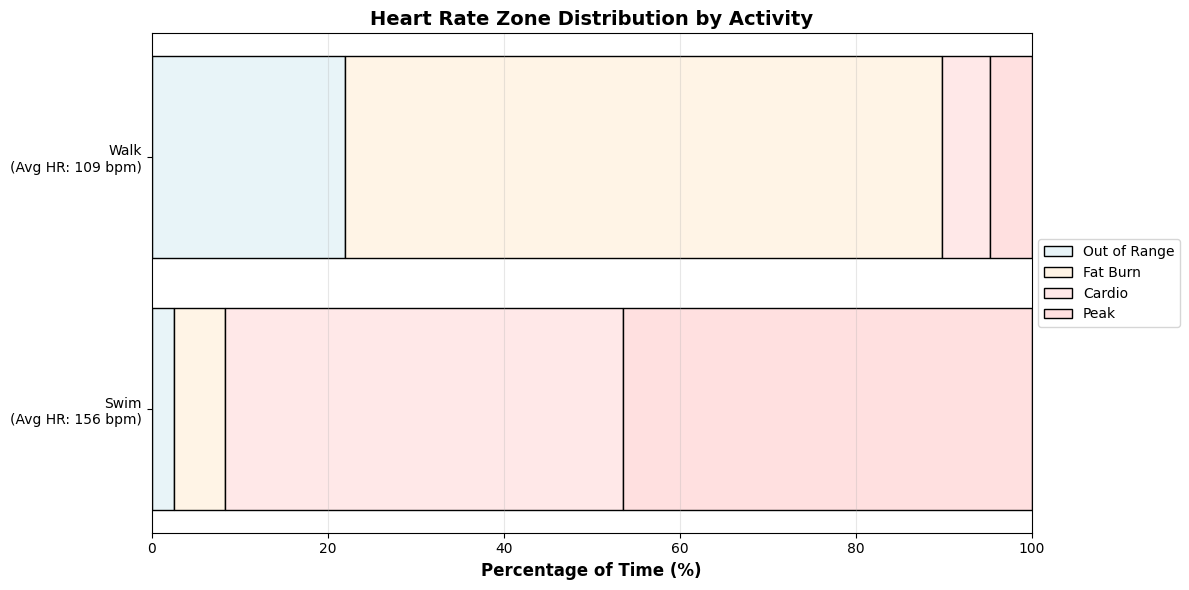


Activity Comparison:

Swim (2025-12-23 20:01:54+00:00):
  Average HR: 155.8 bpm
  Max HR: 205 bpm
  Measurements: 1,577
  Zone breakdown:
    Out of Range   :   2.5%
    Fat Burn       :   5.8%
    Cardio         :  45.1%
    Peak           :  46.5%

Walk (2025-12-23 08:43:07.053000+00:00):
  Average HR: 108.7 bpm
  Max HR: 185 bpm
  Measurements: 423
  Zone breakdown:
    Out of Range   :  22.0%
    Fat Burn       :  67.8%
    Cardio         :   5.4%
    Peak           :   4.7%


In [98]:
# Optional: Compare HR zones between different activities
if len(df_activity_records) > 0 and not df_hr_intra.empty:
    print("="*80)
    print("HEART RATE ZONES BY ACTIVITY")
    print("="*80 + "\n")
    
    from functions.performance_functions import extract_activity_time_window
    
    # Create comparison data
    activity_zone_data = []
    
    for idx, activity in df_activity_records.iterrows():
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Get HR data during this activity
        hr_during_activity = df_hr_intra[
            (df_hr_intra['time'] >= activity_start) & 
            (df_hr_intra['time'] <= activity_end)
        ]
        
        if not hr_during_activity.empty:
            # Calculate zone percentages
            zone_percentages = {}
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_activity[
                    (hr_during_activity['value'] >= zone_info['range'][0]) &
                    (hr_during_activity['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_activity)) * 100
                zone_percentages[zone_name] = pct
            
            activity_zone_data.append({
                'name': activity['ActivityName'],
                'time': activity['time'],
                'zones': zone_percentages,
                'avg_hr': hr_during_activity['value'].mean(),
                'max_hr': hr_during_activity['value'].max(),
                'measurements': len(hr_during_activity)
            })
    
    if activity_zone_data:
        # Create stacked bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        zone_names = list(hr_zones.keys())
        num_activities = len(activity_zone_data)
        
        # Prepare data for stacked bars
        bottom = np.zeros(num_activities)
        
        for zone_name in zone_names:
            percentages = [a['zones'][zone_name] for a in activity_zone_data]
            zone_color = hr_zones[zone_name]['color']
            
            ax.barh(range(num_activities), percentages, left=bottom, 
                   label=zone_name, color=zone_color, edgecolor='black', linewidth=1)
            bottom += percentages
        
        # Customize plot
        activity_labels = [f"{a['name']}\n(Avg HR: {a['avg_hr']:.0f} bpm)" 
                          for a in activity_zone_data]
        ax.set_yticks(range(num_activities))
        ax.set_yticklabels(activity_labels)
        ax.set_xlabel('Percentage of Time (%)', fontsize=12, fontweight='bold')
        ax.set_title('Heart Rate Zone Distribution by Activity', fontsize=14, fontweight='bold')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison
        print("\nActivity Comparison:")
        for a in activity_zone_data:
            print(f"\n{a['name']} ({a['time']}):")
            print(f"  Average HR: {a['avg_hr']:.1f} bpm")
            print(f"  Max HR: {a['max_hr']:.0f} bpm")
            print(f"  Measurements: {a['measurements']:,}")
            print(f"  Zone breakdown:")
            for zone_name, pct in a['zones'].items():
                if pct > 0:
                    print(f"    {zone_name:15s}: {pct:5.1f}%")
    else:
        print("No heart rate data found during activities")
else:
    print("No activities with heart rate data to compare")

FITBIT vs. CALCULATED HR ZONES COMPARISON



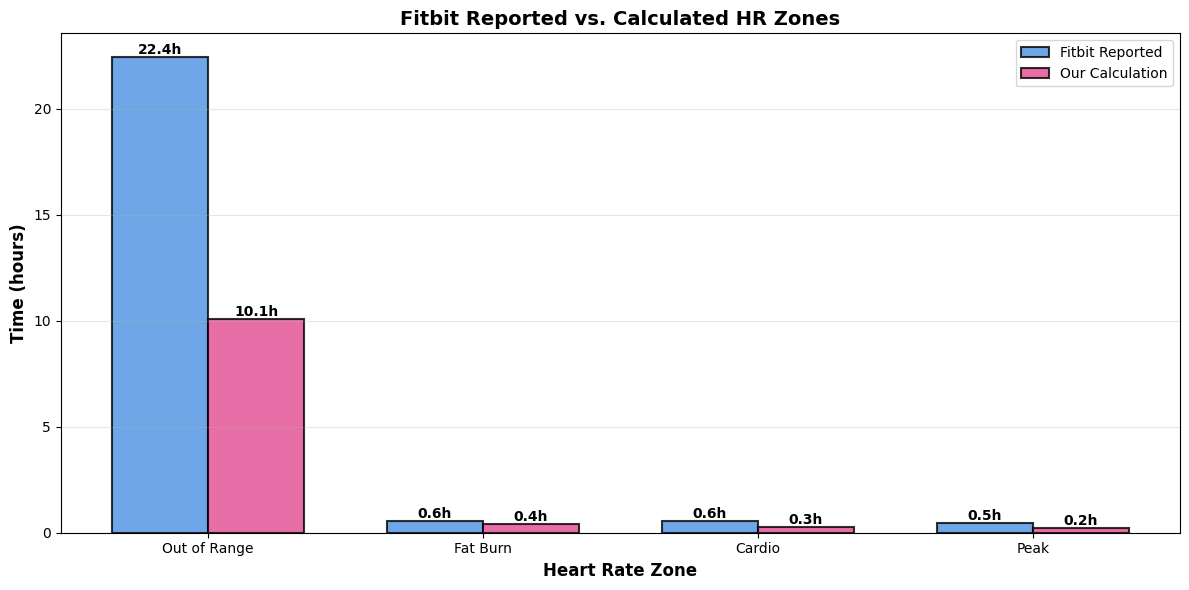


Detailed Comparison:
Zone            |     Fitbit | Calculated | Difference
------------------------------------------------------------
Out of Range    |    1346 min |     603 min |    -743 min
Fat Burn        |      33 min |      25 min |      -8 min
Cardio          |      34 min |      16 min |     -18 min
Peak            |      27 min |      13 min |     -14 min

Note: Differences may occur because:
  - Fitbit uses different zone thresholds based on your profile
  - We're using generic zones (customize with calculate_hr_zones_from_age)
  - Timing differences in data collection


In [99]:
# Compare our calculated zones vs. Fitbit's reported HR_Zones
df_hr_zones_fitbit = dfs.get('HR_Zones', pd.DataFrame())

if not df_hr_zones_fitbit.empty:
    print("="*80)
    print("FITBIT vs. CALCULATED HR ZONES COMPARISON")
    print("="*80 + "\n")
    
    # Get Fitbit's reported zone data
    fitbit_zones = df_hr_zones_fitbit.iloc[0]
    
    # Prepare comparison data
    comparison_data = []
    
    for zone_name in ['Out of Range', 'Fat Burn', 'Cardio', 'Peak']:
        # Fitbit's reported minutes
        fitbit_minutes = fitbit_zones.get(zone_name, 0)
        fitbit_hours = fitbit_minutes / 60
        
        # Our calculated minutes
        calculated_zone = next((z for z in zone_data if z['zone'] == zone_name), None)
        if calculated_zone:
            calculated_minutes = calculated_zone['minutes']
            calculated_hours = calculated_zone['hours']
        else:
            calculated_minutes = 0
            calculated_hours = 0
        
        # Calculate difference
        diff_minutes = calculated_minutes - fitbit_minutes
        diff_hours = diff_minutes / 60
        
        comparison_data.append({
            'zone': zone_name,
            'fitbit_minutes': fitbit_minutes,
            'fitbit_hours': fitbit_hours,
            'calculated_minutes': calculated_minutes,
            'calculated_hours': calculated_hours,
            'diff_minutes': diff_minutes,
            'diff_hours': diff_hours
        })
    
    # Create comparison bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    zones = [c['zone'] for c in comparison_data]
    x = np.arange(len(zones))
    width = 0.35
    
    fitbit_hours = [c['fitbit_hours'] for c in comparison_data]
    calculated_hours = [c['calculated_hours'] for c in comparison_data]
    
    bars1 = ax.bar(x - width/2, fitbit_hours, width, 
                   label='Fitbit Reported', color='#4A90E2', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x + width/2, calculated_hours, width, 
                   label='Our Calculation', color='#E24A90', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}h',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Heart Rate Zone', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Fitbit Reported vs. Calculated HR Zones', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(zones)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    print(f"{'Zone':15s} | {'Fitbit':>10s} | {'Calculated':>10s} | {'Difference':>10s}")
    print("-" * 60)
    
    for c in comparison_data:
        diff_sign = "+" if c['diff_minutes'] >= 0 else ""
        print(f"{c['zone']:15s} | {c['fitbit_minutes']:7.0f} min | {c['calculated_minutes']:7.0f} min | {diff_sign}{c['diff_minutes']:7.0f} min")
    
    print("\nNote: Differences may occur because:")
    print("  - Fitbit uses different zone thresholds based on your profile")
    print("  - We're using generic zones (customize with calculate_hr_zones_from_age)")
    print("  - Timing differences in data collection")
    
else:
    print("No HR_Zones data available from Fitbit")

HEART RATE TIMELINE WITH ACTIVITIES



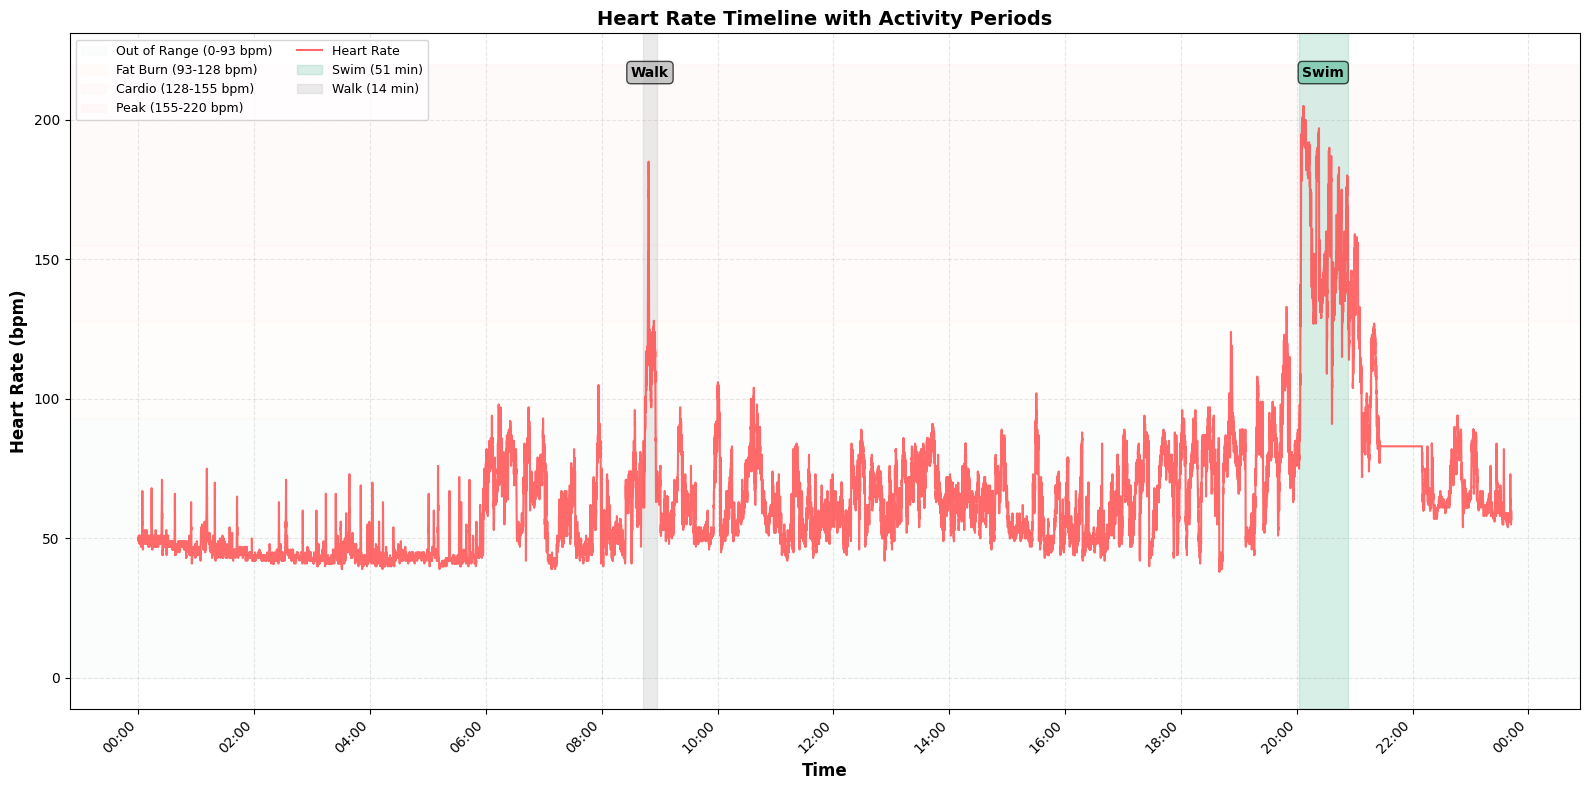


Timeline shows:
  - Colored bands: Heart rate zones
  - Red line: Your actual heart rate throughout the day
  - Highlighted regions: Activity periods
  - You can see how activities affect your HR and which zones you reached


In [100]:
# Timeline view: HR zones with activities highlighted
if not df_hr_intra.empty and len(df_activity_records) > 0:
    print("="*80)
    print("HEART RATE TIMELINE WITH ACTIVITIES")
    print("="*80 + "\n")
    
    from functions.performance_functions import convert_timezone_safe, extract_activity_time_window
    
    # Convert HR data to local timezone for plotting
    df_hr_plot = convert_timezone_safe(df_hr_intra.copy(), target_tz='Europe/London')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot HR zones as background bands
    for zone_name, zone_info in hr_zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                  alpha=0.15, color=zone_info['color'], 
                  label=f"{zone_name} ({zone_info['range'][0]}-{zone_info['range'][1]} bpm)")
    
    # Plot heart rate line
    ax.plot(df_hr_plot['time'], df_hr_plot['value'], 
           color='#ff4444', linewidth=1.5, alpha=0.8, label='Heart Rate', zorder=5)
    
    # Highlight activity periods
    activity_colors = plt.cm.Set2(np.linspace(0, 1, len(df_activity_records)))
    
    for idx, (activity_idx, activity) in enumerate(df_activity_records.iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Add vertical span for activity
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color=activity_colors[idx], 
                  label=f"{activity['ActivityName']} ({duration:.0f} min)", zorder=2)
        
        # Add text label at the top
        mid_time = activity_start + (activity_end - activity_start) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.95, 
               activity['ActivityName'], 
               ha='center', va='top', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=activity_colors[idx], alpha=0.7))
    
    # Customize plot
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title('Heart Rate Timeline with Activity Periods', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTimeline shows:")
    print("  - Colored bands: Heart rate zones")
    print("  - Red line: Your actual heart rate throughout the day")
    print("  - Highlighted regions: Activity periods")
    print("  - You can see how activities affect your HR and which zones you reached")
    
else:
    print("Need both heart rate data and activity records for timeline view")

## 12. Activity Level Distribution

Analyze time spent at different activity levels: Sedentary, Lightly Active, Fairly Active, Very Active

ACTIVITY LEVEL DISTRIBUTION



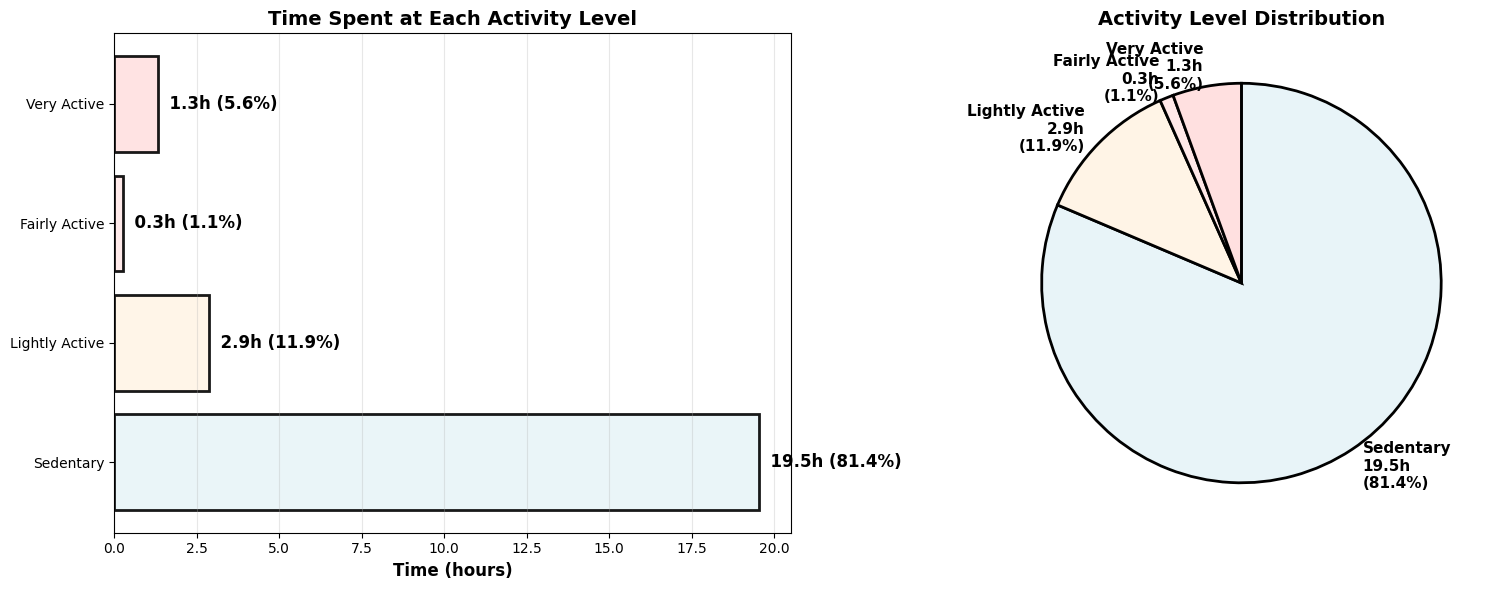


Activity Level Summary:

Sedentary           
  Time: 19.5 hours (1172 minutes)
  Percentage of day: 81.4%

Lightly Active      
  Time: 2.9 hours (172 minutes)
  Percentage of day: 11.9%

Fairly Active       
  Time: 0.3 hours (16 minutes)
  Percentage of day: 1.1%

Very Active         
  Time: 1.3 hours (80 minutes)
  Percentage of day: 5.6%

Total tracked time: 24.0 hours (1440 minutes)
Expected daily total: 24 hours (1440 minutes)


In [101]:
# Extract activity level data
activity_levels = {
    'Sedentary': dfs.get('Activity-minutesSedentary', pd.DataFrame()),
    'Lightly Active': dfs.get('Activity-minutesLightlyActive', pd.DataFrame()),
    'Fairly Active': dfs.get('Activity-minutesFairlyActive', pd.DataFrame()),
    'Very Active': dfs.get('Activity-minutesVeryActive', pd.DataFrame())
}

# Check if we have activity level data
has_data = any(not df.empty for df in activity_levels.values())

if has_data:
    print("="*80)
    print("ACTIVITY LEVEL DISTRIBUTION")
    print("="*80 + "\n")
    
    # Collect data
    level_data = []
    total_minutes = 0
    
    # Define colors for activity levels
    level_colors = {
        'Sedentary': '#E8F4F8',
        'Lightly Active': '#FFF4E6',
        'Fairly Active': '#FFE8E8',
        'Very Active': '#FFE0E0'
    }
    
    for level_name, df in activity_levels.items():
        if not df.empty:
            minutes = df.iloc[0]['value']
            hours = minutes / 60
            total_minutes += minutes
            
            level_data.append({
                'level': level_name,
                'minutes': minutes,
                'hours': hours,
                'color': level_colors[level_name]
            })
    
    # Calculate percentages
    for item in level_data:
        item['percentage'] = (item['minutes'] / total_minutes) * 100 if total_minutes > 0 else 0
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========================================================================
    # Left panel: Bar chart
    # ========================================================================
    
    levels = [item['level'] for item in level_data]
    hours = [item['hours'] for item in level_data]
    colors = [item['color'] for item in level_data]
    
    bars = ax1.barh(levels, hours, color=colors, edgecolor='black', linewidth=2, alpha=0.9)
    
    # Add value labels
    for bar, item in zip(bars, level_data):
        width = bar.get_width()
        label = f"{item['hours']:.1f}h ({item['percentage']:.1f}%)"
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=12, fontweight='bold')
    
    ax1.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    ax1.set_title('Time Spent at Each Activity Level', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # ========================================================================
    # Right panel: Pie chart
    # ========================================================================
    
    pie_labels = [f"{item['level']}\n{item['hours']:.1f}h\n({item['percentage']:.1f}%)" 
                  for item in level_data]
    pie_values = [item['hours'] for item in level_data]
    pie_colors = [item['color'] for item in level_data]
    
    wedges, texts = ax2.pie(pie_values,
                            labels=pie_labels,
                            colors=pie_colors,
                            startangle=90,
                            counterclock=False,
                            wedgeprops={'edgecolor': 'black', 'linewidth': 2},
                            textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    ax2.set_title('Activity Level Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nActivity Level Summary:")
    print("="*60)
    
    for item in level_data:
        print(f"\n{item['level']:20s}")
        print(f"  Time: {item['hours']:.1f} hours ({item['minutes']:.0f} minutes)")
        print(f"  Percentage of day: {item['percentage']:.1f}%")
    
    print(f"\n{'='*60}")
    print(f"Total tracked time: {total_minutes/60:.1f} hours ({total_minutes:.0f} minutes)")
    print(f"Expected daily total: 24 hours (1440 minutes)")
    
    if total_minutes < 1440:
        untracked = 1440 - total_minutes
        print(f"⚠️  Untracked time: {untracked/60:.1f} hours ({untracked:.0f} minutes)")
        print(f"   This may be sleep or device-off time")
    
else:
    print("No activity level data available")


ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON



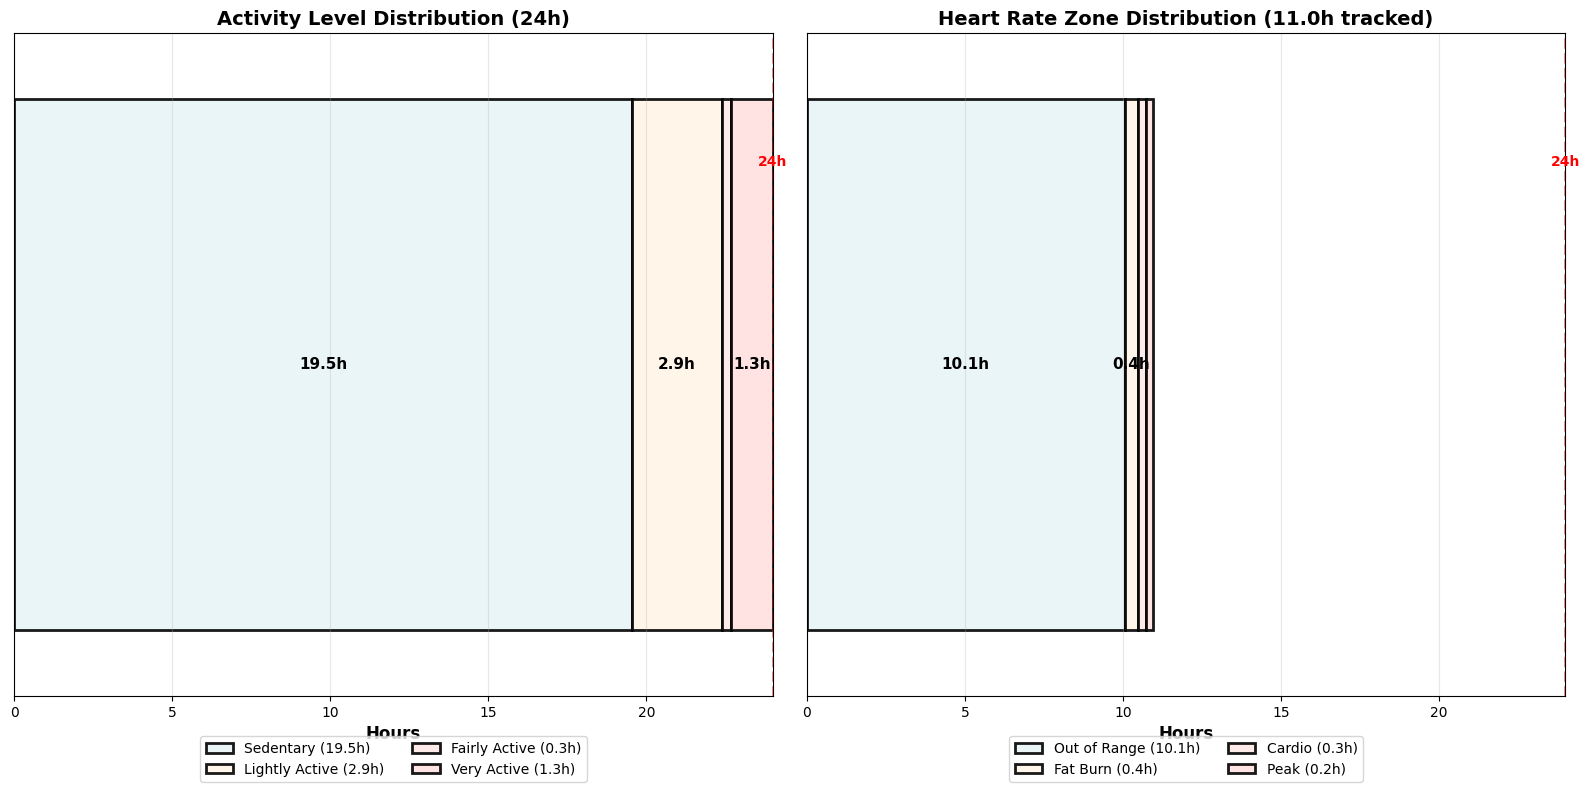


Key Insights:
------------------------------------------------------------

📊 Activity Summary:
   Total Active Time: 4.5 hours (18.6% of day)
   Sedentary Time: 19.5 hours (81.4% of day)

❤️  Heart Rate Summary:
   Elevated HR Time (Fat Burn+): 0.9 hours
   Percentage of tracked HR: 8.2%

🎯 Activity Goal (WHO Guidelines):
   Fairly/Very Active: 96 minutes
   Daily target: ~21 minutes
   ✅ Goal achieved! (448% of target)


In [102]:
# Combined view: Activity Levels vs HR Zones
if has_data and 'zone_data' in globals():
    print("\n" + "="*80)
    print("ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON")
    print("="*80 + "\n")
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # ========================================================================
    # Left: Activity Levels (stacked with total 24h reference)
    # ========================================================================
    
    # Prepare data
    level_names = [item['level'] for item in level_data]
    level_hours = [item['hours'] for item in level_data]
    level_colors_list = [item['color'] for item in level_data]
    
    # Create stacked bar (horizontal)
    left = 0
    for i, (name, hours, color) in enumerate(zip(level_names, level_hours, level_colors_list)):
        ax1.barh(0, hours, left=left, color=color, 
                edgecolor='black', linewidth=2, alpha=0.9, 
                label=f"{name} ({hours:.1f}h)")
        
        # Add text label in the middle of each segment
        if hours > 0.5:  # Only show label if segment is wide enough
            ax1.text(left + hours/2, 0, f"{hours:.1f}h", 
                    ha='center', va='center', fontsize=11, fontweight='bold')
        
        left += hours
    
    # Add untracked time if any
    if total_minutes < 1440:
        untracked_hours = (1440 - total_minutes) / 60
        ax1.barh(0, untracked_hours, left=left, color='#CCCCCC', 
                edgecolor='black', linewidth=2, alpha=0.5, 
                label=f"Untracked ({untracked_hours:.1f}h)")
        if untracked_hours > 0.5:
            ax1.text(left + untracked_hours/2, 0, f"{untracked_hours:.1f}h", 
                    ha='center', va='center', fontsize=11, fontweight='bold')
    
    ax1.set_xlim(0, 24)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_xlabel('Hours', fontsize=12, fontweight='bold')
    ax1.set_title('Activity Level Distribution (24h)', fontsize=14, fontweight='bold')
    ax1.set_yticks([])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add 24h marker
    ax1.axvline(24, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax1.text(24, 0.3, '24h', ha='center', fontsize=10, color='red', fontweight='bold')
    
    # ========================================================================
    # Right: HR Zones (stacked)
    # ========================================================================
    
    zone_names = [z['zone'] for z in zone_data]
    zone_hours = [z['hours'] for z in zone_data]
    zone_colors_list = [z['color'] for z in zone_data]
    
    # Create stacked bar (horizontal)
    left = 0
    total_hr_hours = sum(zone_hours)
    
    for i, (name, hours, color) in enumerate(zip(zone_names, zone_hours, zone_colors_list)):
        if hours > 0:
            ax2.barh(0, hours, left=left, color=color, 
                    edgecolor='black', linewidth=2, alpha=0.9, 
                    label=f"{name} ({hours:.1f}h)")
            
            # Add text label in the middle of each segment
            if hours > 0.3:  # Only show label if segment is wide enough
                ax2.text(left + hours/2, 0, f"{hours:.1f}h", 
                        ha='center', va='center', fontsize=11, fontweight='bold')
            
            left += hours
    
    ax2.set_xlim(0, 24)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Hours', fontsize=12, fontweight='bold')
    ax2.set_title(f'Heart Rate Zone Distribution ({total_hr_hours:.1f}h tracked)', 
                 fontsize=14, fontweight='bold')
    ax2.set_yticks([])
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add 24h marker
    ax2.axvline(24, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax2.text(24, 0.3, '24h', ha='center', fontsize=10, color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("\nKey Insights:")
    print("-" * 60)
    
    # Calculate active time
    active_time = sum(item['hours'] for item in level_data 
                     if item['level'] != 'Sedentary')
    sedentary_time = next((item['hours'] for item in level_data 
                          if item['level'] == 'Sedentary'), 0)
    
    print(f"\n📊 Activity Summary:")
    print(f"   Total Active Time: {active_time:.1f} hours ({(active_time/24)*100:.1f}% of day)")
    print(f"   Sedentary Time: {sedentary_time:.1f} hours ({(sedentary_time/24)*100:.1f}% of day)")
    
    # Calculate elevated HR time
    elevated_hr_zones = ['Fat Burn', 'Cardio', 'Peak']
    elevated_hr_time = sum(z['hours'] for z in zone_data 
                          if z['zone'] in elevated_hr_zones)
    
    print(f"\n❤️  Heart Rate Summary:")
    print(f"   Elevated HR Time (Fat Burn+): {elevated_hr_time:.1f} hours")
    print(f"   Percentage of tracked HR: {(elevated_hr_time/total_hr_hours)*100:.1f}%")
    
    # Activity goal check (WHO recommends 150 min moderate activity/week)
    fairly_very_active = sum(item['minutes'] for item in level_data 
                            if item['level'] in ['Fairly Active', 'Very Active'])
    daily_target = 150 / 7  # ~21.4 minutes per day
    
    print(f"\n🎯 Activity Goal (WHO Guidelines):")
    print(f"   Fairly/Very Active: {fairly_very_active:.0f} minutes")
    print(f"   Daily target: ~{daily_target:.0f} minutes")
    if fairly_very_active >= daily_target:
        print(f"   ✅ Goal achieved! ({(fairly_very_active/daily_target)*100:.0f}% of target)")
    else:
        shortfall = daily_target - fairly_very_active
        print(f"   ⚠️  {shortfall:.0f} minutes short of daily target")

else:
    print("Need both activity level and HR zone data for comparison")